In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
def accuracy_multi(preds, targs, thresh=.5):
    return ((to_np(preds)>thresh)==to_np(targs)).mean()

In [4]:
# Code taken from https://github.com/mutaku/xml2json

import xml.etree.cElementTree as ET
import simplejson, optparse, sys, os

def elem_to_internal(elem,strip=1):

    """Convert an Element into an internal dictionary (not JSON!)."""

    d = {}
    for key, value in elem.attrib.items():
        d['@'+key] = value

    # loop over subelements to merge them
    for subelem in elem:
        v = elem_to_internal(subelem,strip=strip)
        tag = subelem.tag
        value = v[tag]
        try:
            # add to existing list for this tag
            d[tag].append(value)
        except AttributeError:
            # turn existing entry into a list
            d[tag] = [d[tag], value]
        except KeyError:
            # add a new non-list entry
            d[tag] = value
    text = elem.text
    tail = elem.tail
    if strip:
        # ignore leading and trailing whitespace
        if text: text = text.strip()
        if tail: tail = tail.strip()

    if tail:
        d['#tail'] = tail

    if d:
        # use #text element if other attributes exist
        if text: d["#text"] = text
    else:
        # text is the value if no attributes
        d = text or None
    return {elem.tag: d}

def elem2json(elem, strip=1):

    """Convert an ElementTree or Element into a JSON string."""

    if hasattr(elem, 'getroot'):
        elem = elem.getroot()
    return simplejson.dumps(elem_to_internal(elem,strip=strip))

def xml2json(xmlstring,strip=1):

    """Convert an XML string into a JSON string."""

    elem = ET.fromstring(xmlstring)
    return elem2json(elem,strip=strip)

In [11]:
PATH = Path('/home/paperspace/fastai/nba_court_vision/data/annotations')

In [12]:
annotations = [json.loads(xml2json(open(f).read()))['annotation'] for f in PATH.iterdir()]

In [90]:
PATH = Path('/home/paperspace/fastai/nba_court_vision/data/team')

In [91]:
output = []
for i,annot in enumerate(annotations):
    try:
        a_obj = annot['object']
        bb_dicts = [a['bndbox'] for a in a_obj]
        o = a_obj[0]
    except:
        print(i, end=', ')
        pass

    bs = [[int(a['xmin']), 
           int(a['ymin']), 
           int(a['xmax'])-int(a['xmin']), 
           int(a['ymax'])-int(a['ymin'])
          ] for a in bb_dicts]

    cats = [a['name'] for a in a_obj]
    area = [b[2]*b[3] for b in bs]
    fn = [str(PATH/annot['filename'])] * len(bs)

    for a, b, c, f in zip(area, bs, cats, fn):
        output.append({'area':a, 'bbox':b, 'category_id':c, 'id':f})

13, 135, 

In [ ]:
# pickle.dump(output, open('annotations_list.pkl','wb'))

In [92]:
cat2idx = {'player':0, 'hoop':1, 'ft':2, 'ball':3, 'clogo':4}
idx2cat = {v:k for k,v in cat2idx.items()}

In [93]:
from collections import defaultdict
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [94]:
trn_anno = collections.defaultdict(list)

In [95]:
for o in output:
    bb = hw_bb(o['bbox'])
    trn_anno[o['id']].append((bb, cat2idx[o['category_id']]))

In [234]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
#     ax.set_xticks(np.linspace(0, 1000, 500))
#     ax.set_yticks(np.linspace(0, 1000, 500))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

In [100]:
trn_anno_keys = list(trn_anno.keys())

In [208]:
mc = [[idx2cat[p[1]] for p in trn_anno[o]] for o in trn_anno_keys]
mcs = np.array([np.array([cat2idx[p] for p in o]) for o in mc])

In [209]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_anno_keys]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

In [210]:
PATH = Path('/home/paperspace/fastai/nba_court_vision/data')

In [211]:
CLAS_CSV = PATH/'clas.csv'
MBB_CSV = PATH/'mbb.csv'
# df = pd.read_csv(CSV)

In [212]:
df = pd.DataFrame({'fn':trn_anno_keys, 'clas':mcs}, columns=['fn','clas'])
# df.to_csv(CLAS_CSV, index=False)
df = pd.DataFrame({'fn':trn_anno_keys, 'bbox':mbbs}, columns=['fn','bbox'])
# df.to_csv(MBB_CSV, index=False)

In [213]:
df = pd.read_csv(MBB_CSV)

In [214]:
val_idxs = []
for i, r in enumerate(trn_anno_keys):
    if r[51:67] == 'hornets_warriors':
        val_idxs.append(i)

trn_idxs = set(df.index) - set(val_idxs)

In [215]:
val_mcs = [mcs[i] for i in val_idxs]
val_mbbs = [mbbs[i] for i in val_idxs]
trn_mcs = [m for i,m in enumerate(mcs) if i not in val_idxs]
trn_mbbs = [m for i,m in enumerate(mbbs) if i not in val_idxs]

In [216]:
PATH = Path('/home/paperspace/fastai/nba_court_vision')

In [217]:
f_model = resnet34
sz = 1000
bs=8

In [218]:
JPEGS = '../data/team'

In [219]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, bs=bs, 
                                  continuous=True, num_workers=4, val_idxs=val_idxs)

In [220]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [221]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(idx2cat) else idx2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [222]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
        
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [223]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)

In [224]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [236]:
x,y = to_np(next(iter(md.val_dl)))
x=md.trn_ds.ds.denorm(x)

In [226]:
x,y = to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)

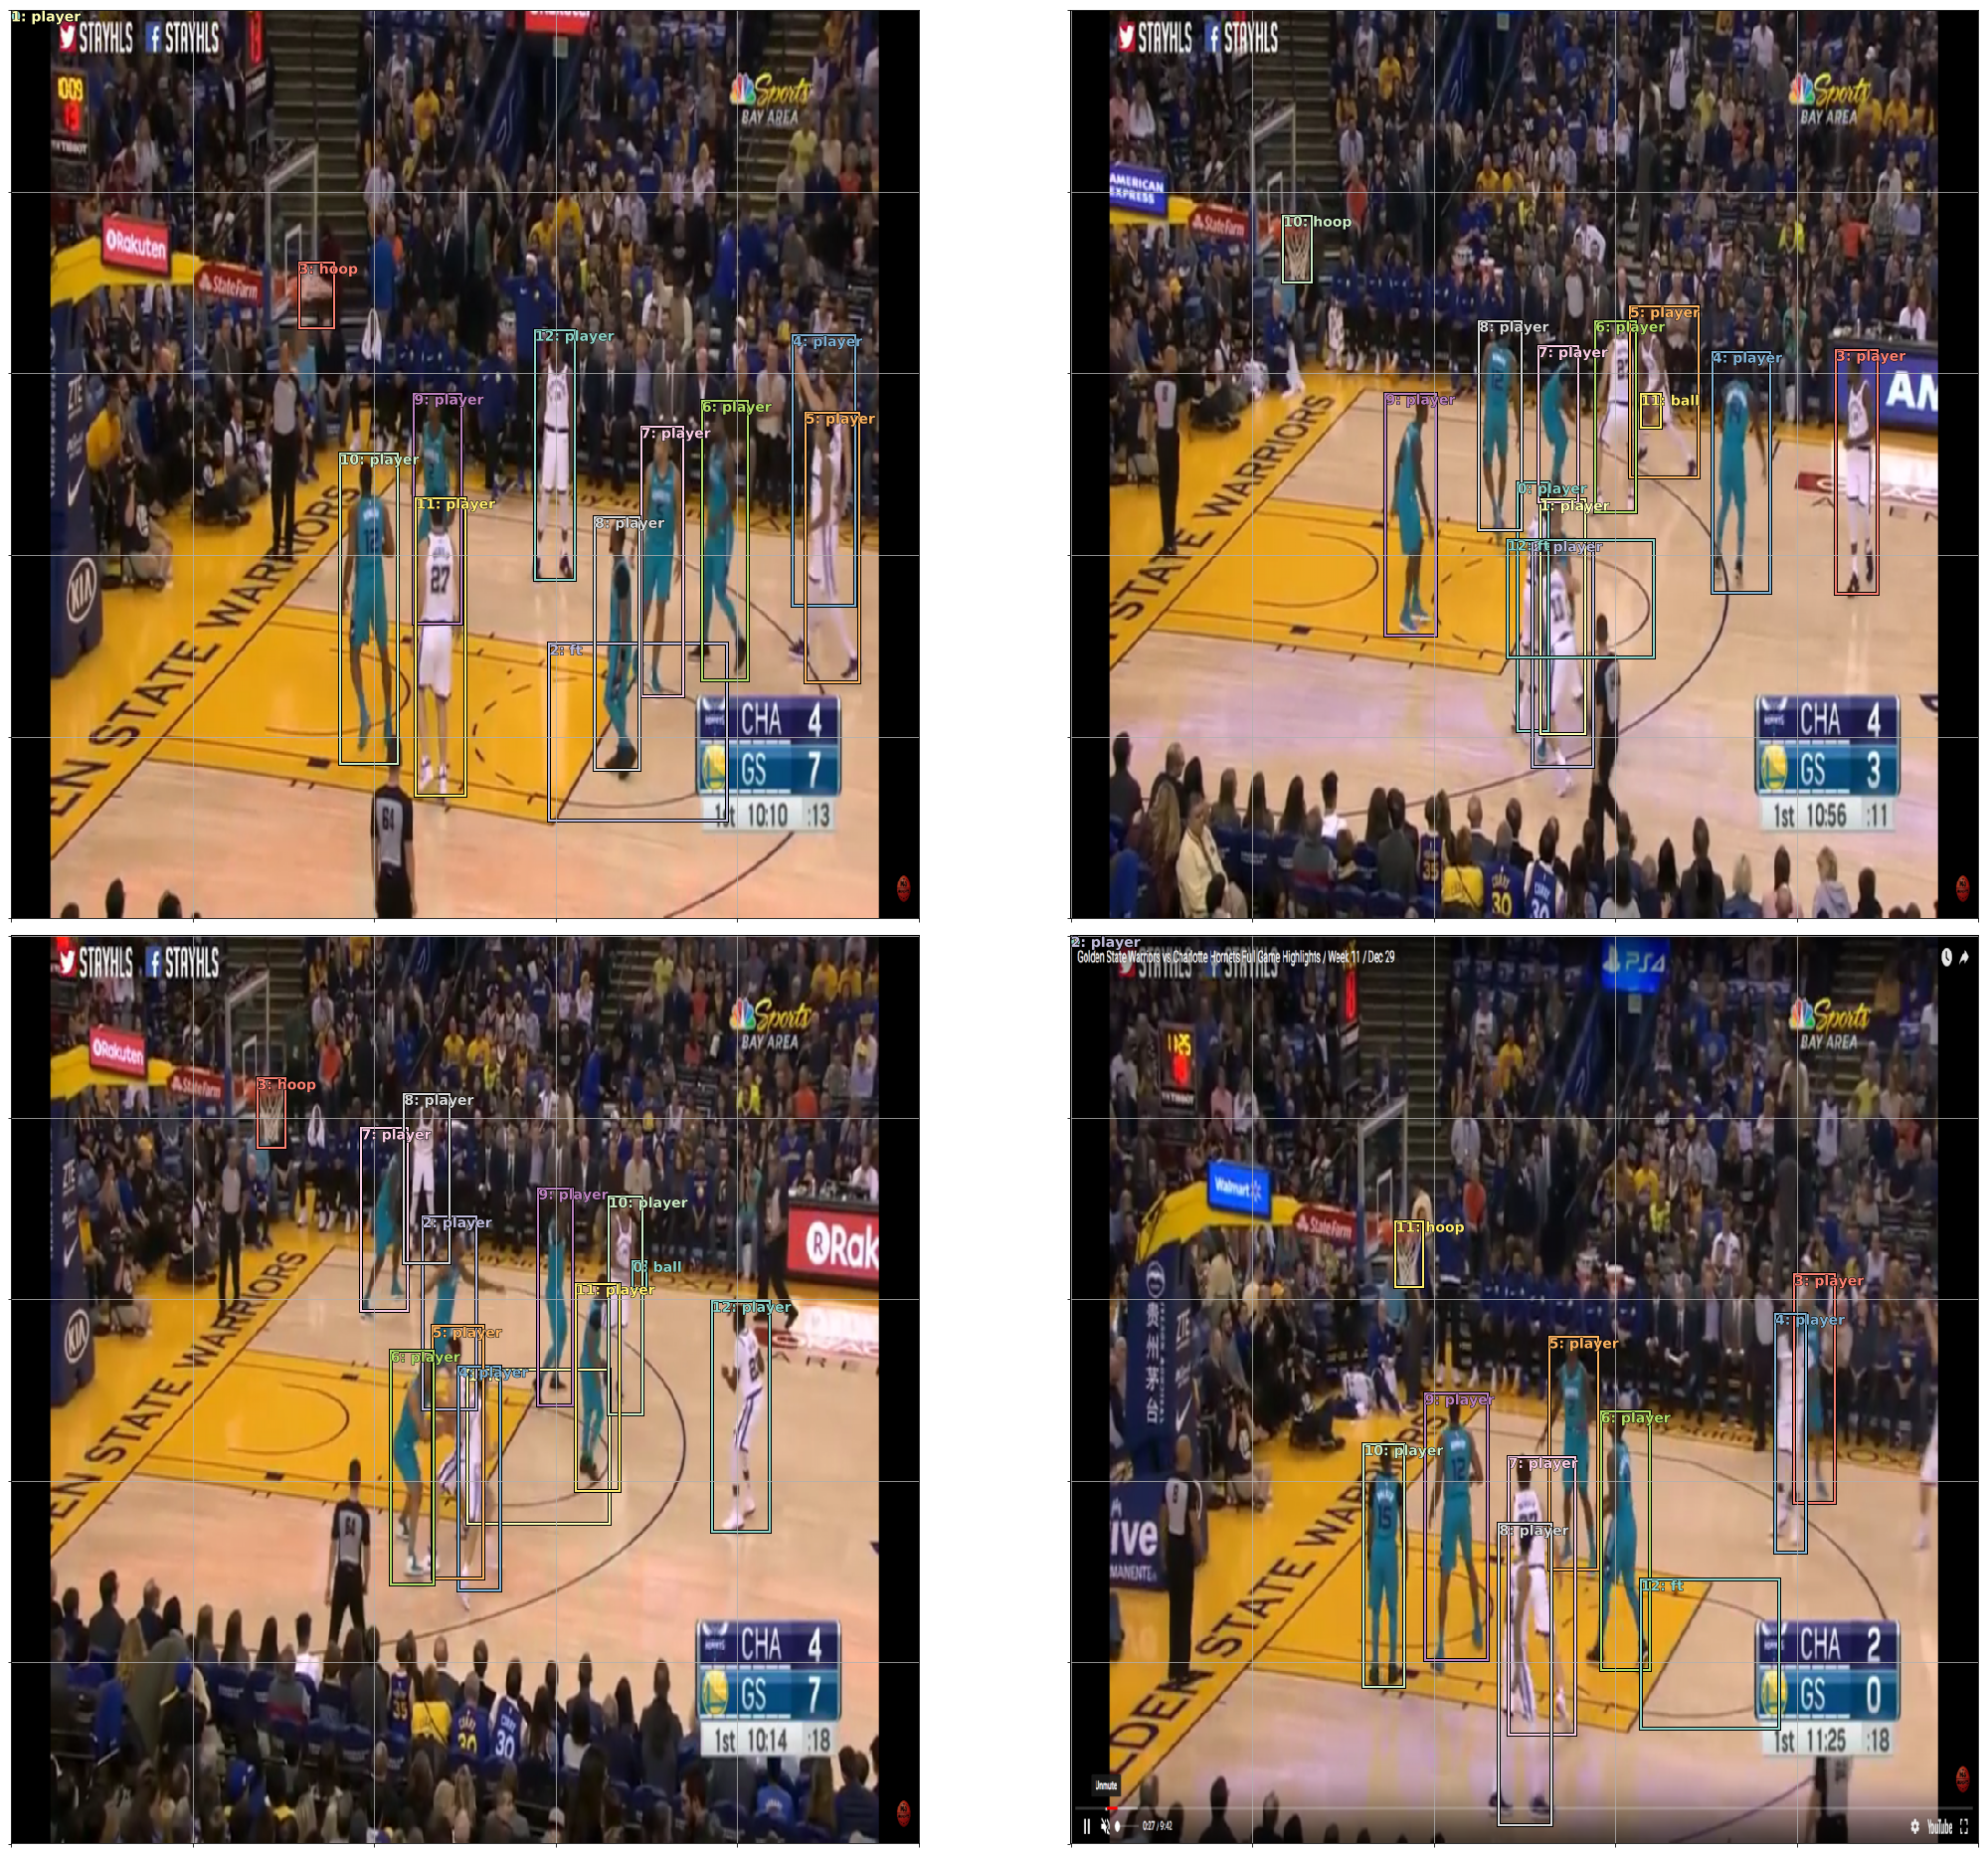

In [237]:
fig_, axes = plt.subplots(2, 2, figsize=(32,26))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

In [ ]:
im_path, bbs = list(trn_anno.items())[i]
i += 1

ax = show_img(plt.imread(im_path))
for bb in bbs:
    draw_rect(ax, bb_hw(bb[0]))

In [ ]:

#     if r['fn'][50:65]

In [ ]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms, val_idxs=val_idxs, bs=bs)

In [ ]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy_multi])

In [ ]:
learn.opt_fn = optim.Adam

In [ ]:
lrf = learn.lr_find()

In [ ]:
learn.sched.plot(0)

In [ ]:
learn.fit(.05, 1, cycle_len=3)

In [ ]:
plt.imshow(plt.imread(md.val_ds.fnames[2]))

In [ ]:
preds = learn.predict()

In [ ]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [ ]:
anc_grid = 6
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [ ]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

In [ ]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [ ]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [ ]:
n_clas = len(idx2cat)+1
n_act = k*(4+n_clas)

In [ ]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [ ]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(idx2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [ ]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

In [ ]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [ ]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(idx2cat))

In [ ]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(idx2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [ ]:
x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [ ]:
batch = learn.model(x)

In [ ]:
anchors = anchors.cpu(); grid_sizes = grid_sizes.cpu(); anchor_cnr = anchor_cnr.cpu()

In [ ]:
md.classes

In [ ]:
yt = []
for i,o in enumerate(y): yt.append(o.cpu())
learn.model.cpu()

In [ ]:
ssd_loss(batch, yt, True)

In [ ]:
%debug